<img src="../BHlogo.png" width="20%">

# Intro to BayesHopper

This tutorial is intended to help anyone learn how to run BayesHopper, a trans-dimensional sampler for pulsar timing array data analysis. To learn more about how BayesHopper works, read the paper describing it at https://arxiv.org/abs/1912.08807

### Installation

After installing `enterprise` (https://github.com/nanograv/enterprise) and `enterprise_extensions` (https://github.com/nanograv/enterprise_extensions), `BayesHopper` should work by just importing it from the cloned GitHub repo.

### Tutorial

Provided below is a simple workflow to set up `psr` objects from an example dataset provided, run `BayesHopper` on the dataset, and carry out some simple post processing. The dataset provided contains 20 pulsars timed for 10 years every 30 day, same white noise in each pulsar, a stochastic GW background with an amplitude of $A = 3.98 \times 10^{-15}$, and three continous wave (CW) sources.

The simple post processing provided here contains plotting trace plots of the chain, calculating Bayes-factors for the background and CW sources, and creating a corner plot of the CW parameters.

Any issues or questions can be directed to Bence Bécsy (bencebecsy@montana.edu)!

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
#%load_ext line_profiler
%autoreload 2

exec('from __future__ import division')

import numpy as np
import numdifftools as nd
import os, glob, json 
import matplotlib.pyplot as plt
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

import enterprise_extensions
from enterprise_extensions import models, model_utils

import sys
sys.path.append("..")
import BayesHopper
import healpy as hp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
timdir = './TimFiles/'
pardir = './ParFiles/'

parfiles = sorted(glob.glob(pardir + '/*.par'))
timfiles = sorted(glob.glob(timdir + '/*.tim'))

print(parfiles)
print(timfiles)

['./ParFiles/JPSR00.par', './ParFiles/JPSR01.par', './ParFiles/JPSR02.par', './ParFiles/JPSR03.par', './ParFiles/JPSR04.par', './ParFiles/JPSR05.par', './ParFiles/JPSR06.par', './ParFiles/JPSR07.par', './ParFiles/JPSR08.par', './ParFiles/JPSR09.par', './ParFiles/JPSR10.par', './ParFiles/JPSR11.par', './ParFiles/JPSR12.par', './ParFiles/JPSR13.par', './ParFiles/JPSR14.par', './ParFiles/JPSR15.par', './ParFiles/JPSR16.par', './ParFiles/JPSR17.par', './ParFiles/JPSR18.par', './ParFiles/JPSR19.par']
['./TimFiles/fake_JPSR00_study4_highergwb.tim', './TimFiles/fake_JPSR01_study4_highergwb.tim', './TimFiles/fake_JPSR02_study4_highergwb.tim', './TimFiles/fake_JPSR03_study4_highergwb.tim', './TimFiles/fake_JPSR04_study4_highergwb.tim', './TimFiles/fake_JPSR05_study4_highergwb.tim', './TimFiles/fake_JPSR06_study4_highergwb.tim', './TimFiles/fake_JPSR07_study4_highergwb.tim', './TimFiles/fake_JPSR08_study4_highergwb.tim', './TimFiles/fake_JPSR09_study4_highergwb.tim', './TimFiles/fake_JPSR10_stud

In [8]:
print(len(parfiles))

psrs = []
for p, t in zip(parfiles, timfiles):
    #print(p)
    psr = Pulsar(p, t, ephem='DE436', clk=None)
    psrs.append(psr)

20


In [20]:
%%time

#number of chains should be set to have a spacing below 2 (maybe even below 1.5)

N=int(1e4) #10k samples should run in a couple minutes and should be sufficient to try out Bayeshopper
#Many more samples are required for proper analysis
T_max = 2.5
n_chain = 4

samples, acc_fraction, swap_record, rj_record =  BayesHopper.run_ptmcmc(N, T_max,n_chain,
                                                                        psrs[::4], #using only every 4th pulsar to speed up example run
                                                                        n_source_prior='flat',
                                                                        max_n_source=10, #max number of CW sources allowed
                                                                        RJ_weight=2, #weight of step adding/removing CWs
                                                                        regular_weight=3, #weight of Fisher jumps
                                                                        noise_jump_weight=4, #weight of Fisher jumps on noise parameters
                                                                        PT_swap_weight=4, #weight of parallel tempering swaps
                                                                        Fe_proposal_weight=3, #weight of global proposals
                                                                        gwb_switch_weight=2, #weight of spet turning GWB on/off
                                                                        fe_file="fstat_map_example.npz", #proposal map used for global proposal - provided for this example
                                                                        gwb_log_amp_range=[-18,-13],
                                                                        rn_log_amp_range=[-18,-13],
                                                                        cw_log_amp_range=[-18,-13],
                                                                        gwb_amp_prior='uniform',
                                                                        rn_amp_prior='uniform',
                                                                        cw_amp_prior='uniform',
                                                                        gwb_on_prior=0.5,
                                                                        draw_from_prior_weight=0, de_weight=0, 
                                                                        vary_white_noise=True,
                                                                        include_gwb=True, include_psr_term=False,
                                                                        include_rn=True, vary_rn=True)

[[<enterprise.signals.signal_base.PTA object at 0x7f2bbb6aa320>, <enterprise.signals.signal_base.PTA object at 0x7f2bbb6aadd8>], [<enterprise.signals.signal_base.PTA object at 0x7f2bbb6cd2b0>, <enterprise.signals.signal_base.PTA object at 0x7f2bbb65e4a8>], [<enterprise.signals.signal_base.PTA object at 0x7f2bbb66ea90>, <enterprise.signals.signal_base.PTA object at 0x7f2bbb615048>], [<enterprise.signals.signal_base.PTA object at 0x7f2bbb626860>, <enterprise.signals.signal_base.PTA object at 0x7f2bbb639da0>], [<enterprise.signals.signal_base.PTA object at 0x7f2bbb5dd978>, <enterprise.signals.signal_base.PTA object at 0x7f2bbb6000f0>], [<enterprise.signals.signal_base.PTA object at 0x7f2bbb5ae0b8>, <enterprise.signals.signal_base.PTA object at 0x7f2bbb5bdd68>], [<enterprise.signals.signal_base.PTA object at 0x7f2bbb562c50>, <enterprise.signals.signal_base.PTA object at 0x7f2bbb588940>], [<enterprise.signals.signal_base.PTA object at 0x7f2bbb52f6d8>, <enterprise.signals.signal_base.PTA obj

Percentage of steps doing different jumps:
PT swaps: 22.22%
RJ moves: 11.11%
GWB-switches: 11.11%
Fe-proposals: 16.67%
Jumps along Fisher eigendirections: 16.67%
Draw from prior: 0.00%
Differential evolution jump: 0.00%
Noise jump: 22.22%
Progress: 0.00% Acceptance fraction (RJ, swap, each chain): (nan, nan, nan, nan, nan, nan)
Progress: 0.10% Acceptance fraction (RJ, swap, each chain): (nan, 1.00, 0.33, 0.56, 0.67, 0.44)
Progress: 0.20% Acceptance fraction (RJ, swap, each chain): (0.50, 0.33, 0.56, 0.38, 0.62, 0.44)
Progress: 0.30% Acceptance fraction (RJ, swap, each chain): (0.25, 0.50, 0.45, 0.35, 0.60, 0.40)
Progress: 0.40% Acceptance fraction (RJ, swap, each chain): (0.25, 0.44, 0.46, 0.38, 0.62, 0.46)
Progress: 0.50% Acceptance fraction (RJ, swap, each chain): (0.25, 0.36, 0.47, 0.43, 0.60, 0.50)
Progress: 0.60% Acceptance fraction (RJ, swap, each chain): (0.33, 0.31, 0.49, 0.46, 0.60, 0.49)
Progress: 0.70% Acceptance fraction (RJ, swap, each chain): (0.35, 0.29, 0.51, 0.46, 0.63

../BayesHopper.py:746: RuntimeWarning: invalid value encountered in double_scalars
  log_acc_ratio += -ptas[n_source][gwb_on].get_lnlikelihood(samples_current)/Ts[j]


Progress: 2.00% Acceptance fraction (RJ, swap, each chain): (0.29, 0.36, 0.38, 0.51, 0.46, 0.57)
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
Progress: 2.10% Acceptance fraction (RJ, swap, each chain): (0.28, 0.34, 0.39, 0.52, 0.48, 0.58)
Progress: 2.20% Acceptance fraction (RJ, swap, each chain): (0.30, 0.37, 0.40, 0.49, 0.50, 0.58)
Progress: 2.30% Acceptance fraction (RJ, swap, each chain): (0.30, 0.38, 0.40, 0.49, 0.50, 0.57)
Progress: 2.40% Acceptance fraction (RJ, swap, each chain): (0.28, 0.38, 0.41, 0.49, 0.50, 0.57)
Progress: 2.50% Acceptance fraction (RJ, swap, each chain): (0.28, 0.38, 0.41, 0.49, 0.49, 0.57)
Progress: 2.60% Acceptance fraction (RJ, swap, each chain): (0.28, 0.38, 0.40, 0.46, 0.48, 0.57)
Progress: 2.70% Acceptance fraction (RJ, swap, each chain): (0.27, 0.42, 0.41, 0.46, 0.48, 0.57)
Progress: 2.80% Acceptance fraction (RJ, swap, each chain): (0.27, 0.43, 0.40, 0.47, 0.48, 0.56)
Progress: 2.90% Acc

Progress: 10.40% Acceptance fraction (RJ, swap, each chain): (0.15, 0.57, 0.46, 0.47, 0.48, 0.52)
Progress: 10.50% Acceptance fraction (RJ, swap, each chain): (0.15, 0.57, 0.46, 0.47, 0.48, 0.52)
Progress: 10.60% Acceptance fraction (RJ, swap, each chain): (0.15, 0.57, 0.46, 0.47, 0.48, 0.52)
Progress: 10.70% Acceptance fraction (RJ, swap, each chain): (0.15, 0.57, 0.46, 0.47, 0.48, 0.52)
Progress: 10.80% Acceptance fraction (RJ, swap, each chain): (0.15, 0.56, 0.46, 0.47, 0.48, 0.52)
Progress: 10.90% Acceptance fraction (RJ, swap, each chain): (0.15, 0.56, 0.46, 0.46, 0.49, 0.52)
Progress: 11.00% Acceptance fraction (RJ, swap, each chain): (0.15, 0.55, 0.46, 0.46, 0.48, 0.52)
Progress: 11.10% Acceptance fraction (RJ, swap, each chain): (0.15, 0.55, 0.46, 0.46, 0.48, 0.52)
Progress: 11.20% Acceptance fraction (RJ, swap, each chain): (0.15, 0.54, 0.46, 0.46, 0.48, 0.52)
Progress: 11.30% Acceptance fraction (RJ, swap, each chain): (0.15, 0.55, 0.46, 0.46, 0.48, 0.51)
Progress: 11.40% Acc

../BayesHopper.py:999: RuntimeWarning: invalid value encountered in double_scalars
  log_acc_ratio += ptas[n_source2][gwb_on2].get_lnlikelihood(samples_current2) / Ts[swap_chain]


Progress: 15.40% Acceptance fraction (RJ, swap, each chain): (0.14, 0.56, 0.46, 0.47, 0.47, 0.50)
Progress: 15.50% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.46, 0.47, 0.47, 0.50)
Progress: 15.60% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.46, 0.47, 0.48, 0.50)
Progress: 15.70% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.47, 0.50)
Progress: 15.80% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.47, 0.51)
Progress: 15.90% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.47, 0.51)


../BayesHopper.py:959: RuntimeWarning: invalid value encountered in double_scalars
  log_acc_ratio += -ptas[n_source][gwb_on].get_lnlikelihood(samples_current)/Ts[j]


Progress: 16.00% Acceptance fraction (RJ, swap, each chain): (0.14, 0.56, 0.47, 0.47, 0.47, 0.51)
Progress: 16.10% Acceptance fraction (RJ, swap, each chain): (0.14, 0.56, 0.47, 0.47, 0.47, 0.51)
Progress: 16.20% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.47, 0.51)
Progress: 16.30% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.47, 0.51)
Progress: 16.40% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.47, 0.51)
Progress: 16.50% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.47, 0.51)
Progress: 16.60% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.48, 0.51)
Progress: 16.70% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.48, 0.51)
Progress: 16.80% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.48, 0.51)
Progress: 16.90% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.47, 0.47, 0.48, 0.51)
Progress: 17.00% Acc

Progress: 24.40% Acceptance fraction (RJ, swap, each chain): (0.14, 0.55, 0.47, 0.47, 0.48, 0.50)
Progress: 24.50% Acceptance fraction (RJ, swap, each chain): (0.14, 0.55, 0.46, 0.47, 0.48, 0.50)
Progress: 24.60% Acceptance fraction (RJ, swap, each chain): (0.14, 0.55, 0.46, 0.47, 0.48, 0.50)
Progress: 24.70% Acceptance fraction (RJ, swap, each chain): (0.14, 0.55, 0.46, 0.47, 0.48, 0.50)
Progress: 24.80% Acceptance fraction (RJ, swap, each chain): (0.14, 0.55, 0.46, 0.47, 0.48, 0.50)
Progress: 24.90% Acceptance fraction (RJ, swap, each chain): (0.14, 0.54, 0.46, 0.47, 0.48, 0.50)
Progress: 25.00% Acceptance fraction (RJ, swap, each chain): (0.14, 0.55, 0.46, 0.47, 0.48, 0.50)
Progress: 25.10% Acceptance fraction (RJ, swap, each chain): (0.14, 0.54, 0.46, 0.47, 0.48, 0.50)
Progress: 25.20% Acceptance fraction (RJ, swap, each chain): (0.14, 0.55, 0.46, 0.47, 0.48, 0.50)
Progress: 25.30% Acceptance fraction (RJ, swap, each chain): (0.14, 0.55, 0.46, 0.47, 0.48, 0.50)
Progress: 25.40% Acc

Progress: 32.80% Acceptance fraction (RJ, swap, each chain): (0.14, 0.56, 0.46, 0.48, 0.47, 0.49)
Progress: 32.90% Acceptance fraction (RJ, swap, each chain): (0.14, 0.56, 0.46, 0.48, 0.47, 0.49)
Progress: 33.00% Acceptance fraction (RJ, swap, each chain): (0.14, 0.56, 0.46, 0.48, 0.47, 0.49)
Progress: 33.10% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.46, 0.48, 0.47, 0.49)
Progress: 33.20% Acceptance fraction (RJ, swap, each chain): (0.14, 0.56, 0.46, 0.48, 0.47, 0.49)
Progress: 33.30% Acceptance fraction (RJ, swap, each chain): (0.14, 0.56, 0.46, 0.48, 0.47, 0.49)
Progress: 33.40% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.49)
Progress: 33.50% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.49)
Progress: 33.60% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.46, 0.48, 0.47, 0.49)
Progress: 33.70% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.46, 0.48, 0.47, 0.49)
Progress: 33.80% Acc

Progress: 41.20% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.44, 0.48, 0.47, 0.48)
Progress: 41.30% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.48)
Progress: 41.40% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.48)
Progress: 41.50% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.48)
Progress: 41.60% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.48)
Progress: 41.70% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.48)
Progress: 41.80% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.48)
Progress: 41.90% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.48)
Progress: 42.00% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.48)
Progress: 42.10% Acceptance fraction (RJ, swap, each chain): (0.14, 0.57, 0.45, 0.48, 0.47, 0.48)
Progress: 42.20% Acc

Progress: 49.60% Acceptance fraction (RJ, swap, each chain): (0.14, 0.58, 0.44, 0.48, 0.47, 0.48)
Progress: 49.70% Acceptance fraction (RJ, swap, each chain): (0.14, 0.58, 0.44, 0.48, 0.47, 0.48)
Progress: 49.80% Acceptance fraction (RJ, swap, each chain): (0.14, 0.58, 0.44, 0.48, 0.47, 0.48)
Progress: 49.90% Acceptance fraction (RJ, swap, each chain): (0.14, 0.58, 0.44, 0.48, 0.47, 0.48)
Progress: 50.00% Acceptance fraction (RJ, swap, each chain): (0.14, 0.58, 0.44, 0.48, 0.47, 0.48)
Progress: 50.10% Acceptance fraction (RJ, swap, each chain): (0.14, 0.58, 0.44, 0.48, 0.47, 0.48)
Progress: 50.20% Acceptance fraction (RJ, swap, each chain): (0.14, 0.58, 0.44, 0.48, 0.47, 0.48)
Progress: 50.30% Acceptance fraction (RJ, swap, each chain): (0.14, 0.58, 0.44, 0.48, 0.47, 0.48)
Progress: 50.40% Acceptance fraction (RJ, swap, each chain): (0.14, 0.58, 0.44, 0.48, 0.47, 0.48)
Progress: 50.50% Acceptance fraction (RJ, swap, each chain): (0.14, 0.58, 0.44, 0.48, 0.47, 0.48)
Progress: 50.60% Acc

Progress: 58.00% Acceptance fraction (RJ, swap, each chain): (0.14, 0.59, 0.44, 0.49, 0.47, 0.47)
Progress: 58.10% Acceptance fraction (RJ, swap, each chain): (0.14, 0.59, 0.44, 0.49, 0.47, 0.47)
Progress: 58.20% Acceptance fraction (RJ, swap, each chain): (0.14, 0.59, 0.44, 0.49, 0.47, 0.47)
Progress: 58.30% Acceptance fraction (RJ, swap, each chain): (0.14, 0.59, 0.44, 0.49, 0.47, 0.47)
Progress: 58.40% Acceptance fraction (RJ, swap, each chain): (0.14, 0.59, 0.44, 0.49, 0.47, 0.47)
Progress: 58.50% Acceptance fraction (RJ, swap, each chain): (0.14, 0.59, 0.44, 0.49, 0.47, 0.47)
Progress: 58.60% Acceptance fraction (RJ, swap, each chain): (0.13, 0.59, 0.44, 0.49, 0.47, 0.47)
Progress: 58.70% Acceptance fraction (RJ, swap, each chain): (0.13, 0.59, 0.44, 0.49, 0.47, 0.47)
Progress: 58.80% Acceptance fraction (RJ, swap, each chain): (0.13, 0.59, 0.44, 0.49, 0.47, 0.47)
Progress: 58.90% Acceptance fraction (RJ, swap, each chain): (0.13, 0.59, 0.44, 0.49, 0.47, 0.47)
Progress: 59.00% Acc

Progress: 66.40% Acceptance fraction (RJ, swap, each chain): (0.13, 0.61, 0.44, 0.50, 0.47, 0.47)
Progress: 66.50% Acceptance fraction (RJ, swap, each chain): (0.13, 0.61, 0.44, 0.50, 0.47, 0.47)
Progress: 66.60% Acceptance fraction (RJ, swap, each chain): (0.13, 0.61, 0.44, 0.50, 0.47, 0.47)
Progress: 66.70% Acceptance fraction (RJ, swap, each chain): (0.13, 0.61, 0.44, 0.50, 0.47, 0.47)
Progress: 66.80% Acceptance fraction (RJ, swap, each chain): (0.13, 0.61, 0.44, 0.50, 0.47, 0.47)
Progress: 66.90% Acceptance fraction (RJ, swap, each chain): (0.13, 0.61, 0.44, 0.50, 0.47, 0.47)
Progress: 67.00% Acceptance fraction (RJ, swap, each chain): (0.13, 0.61, 0.44, 0.50, 0.47, 0.47)
Progress: 67.10% Acceptance fraction (RJ, swap, each chain): (0.13, 0.61, 0.44, 0.50, 0.47, 0.47)
Progress: 67.20% Acceptance fraction (RJ, swap, each chain): (0.13, 0.61, 0.44, 0.50, 0.47, 0.47)
Progress: 67.30% Acceptance fraction (RJ, swap, each chain): (0.13, 0.61, 0.44, 0.50, 0.47, 0.47)
Progress: 67.40% Acc

Progress: 74.90% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.45, 0.51, 0.47, 0.48)
Progress: 75.00% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.45, 0.51, 0.47, 0.48)
Progress: 75.10% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.45, 0.51, 0.47, 0.48)
Progress: 75.20% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.45, 0.51, 0.47, 0.48)
Progress: 75.30% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.45, 0.51, 0.47, 0.48)
Progress: 75.40% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.45, 0.51, 0.47, 0.48)
Progress: 75.50% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.45, 0.51, 0.47, 0.48)
Progress: 75.60% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.45, 0.51, 0.47, 0.48)
Progress: 75.70% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.45, 0.50, 0.47, 0.48)
Progress: 75.80% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.45, 0.51, 0.47, 0.48)
Progress: 75.90% Acc

Progress: 83.30% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.44, 0.50, 0.47, 0.48)
Progress: 83.40% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.44, 0.50, 0.47, 0.48)
Progress: 83.50% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.44, 0.50, 0.47, 0.48)
Progress: 83.60% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.44, 0.50, 0.47, 0.48)
Progress: 83.70% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.44, 0.50, 0.47, 0.48)
Progress: 83.80% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.44, 0.50, 0.47, 0.48)
Progress: 83.90% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.44, 0.50, 0.47, 0.48)
Progress: 84.00% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.44, 0.50, 0.47, 0.48)
Progress: 84.10% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.44, 0.50, 0.47, 0.48)
Progress: 84.20% Acceptance fraction (RJ, swap, each chain): (0.13, 0.62, 0.44, 0.50, 0.47, 0.48)
Progress: 84.30% Acc

Progress: 91.70% Acceptance fraction (RJ, swap, each chain): (0.13, 0.63, 0.44, 0.51, 0.47, 0.48)
Progress: 91.80% Acceptance fraction (RJ, swap, each chain): (0.13, 0.63, 0.44, 0.51, 0.47, 0.48)
Progress: 91.90% Acceptance fraction (RJ, swap, each chain): (0.13, 0.63, 0.44, 0.51, 0.47, 0.48)
Progress: 92.00% Acceptance fraction (RJ, swap, each chain): (0.13, 0.63, 0.44, 0.51, 0.47, 0.48)
Progress: 92.10% Acceptance fraction (RJ, swap, each chain): (0.13, 0.63, 0.44, 0.51, 0.47, 0.48)
Progress: 92.20% Acceptance fraction (RJ, swap, each chain): (0.13, 0.63, 0.44, 0.51, 0.47, 0.48)
Progress: 92.30% Acceptance fraction (RJ, swap, each chain): (0.13, 0.63, 0.44, 0.51, 0.47, 0.48)
Progress: 92.40% Acceptance fraction (RJ, swap, each chain): (0.13, 0.63, 0.45, 0.51, 0.47, 0.48)
Progress: 92.50% Acceptance fraction (RJ, swap, each chain): (0.13, 0.63, 0.45, 0.51, 0.47, 0.48)
Progress: 92.60% Acceptance fraction (RJ, swap, each chain): (0.13, 0.63, 0.45, 0.51, 0.47, 0.48)
Progress: 92.70% Acc

(10000, 79)
5
1.0
[  3.          -0.68412061  -0.31921357   1.7321871   -7.08112707
 -13.49643326   5.53247999   1.96270399   0.79413342  -0.58296229
   3.78903802  -8.14772658 -13.69916663   2.55087133   1.27388179
  -0.25871299   0.23489433   5.22156796  -7.55099552 -14.34192365
   1.13604576   1.37003843   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           1.           1.           1.           1.           1.
   5.27466391 -14.37273976 -13.20041853]


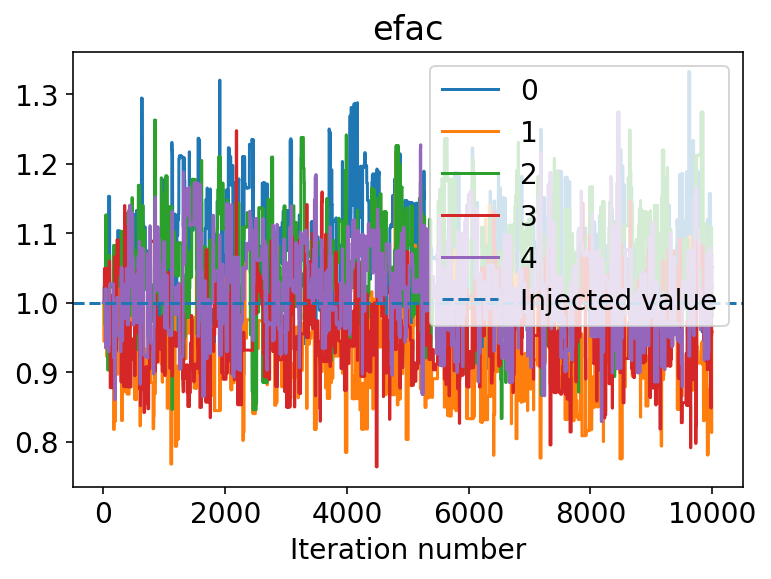

In [28]:
#################################################################
#
# WHITE NOISE PARAMETERS TRACE PLOT
#
#################################################################

samples_burned = samples[0,:,:]

print(samples_burned.shape)
n_pulsar=5
max_n_source=10
print(n_pulsar)

true_val1 = 1.0
prior_upper = 0.01
prior_lower = 10
print(true_val1)

print(samples_burned[0,:])

plt.figure(0)
for j in range(n_pulsar):
    plt.plot(samples_burned[:,1+max_n_source*7+j], label=str(j))
plt.title('efac')
plt.xlabel("Iteration number")
#plt.gca().axhline(y=prior_upper, linestyle='-', label="Prior boundary")
#plt.gca().axhline(y=prior_lower, linestyle='-')
plt.gca().axhline(y=true_val1, linestyle='--', label="Injected value")
plt.legend()

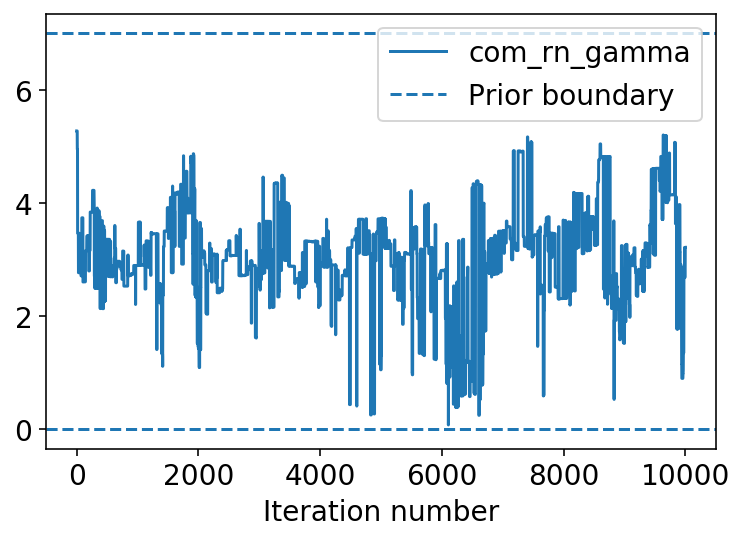

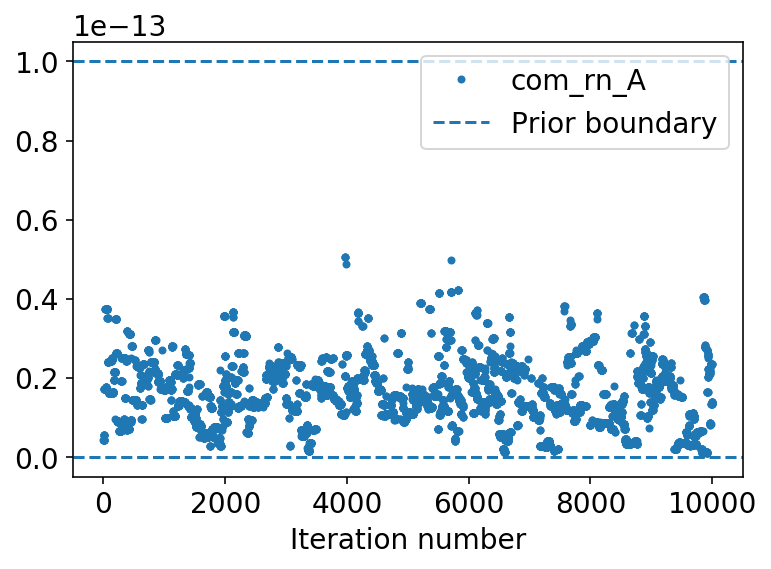

In [29]:
#################################################################
#
# RED NOISE PARAMETERS TRACE PLOT
#
#################################################################

samples_burned = samples[0,:,:]

true_val1 = [0, -20]
prior_upper = [0, -20]
prior_lower = [7, -13]

num_psrs = 5

plt.figure(1)
plt.plot(samples_burned[:,1+max_n_source*7+num_psrs], label="com_rn_gamma")
#plt.gca().axhline(y=true_val1[0], linestyle='--', label="Injected value")
plt.gca().axhline(y=prior_upper[0], linestyle='--', label="Prior boundary")
plt.gca().axhline(y=prior_lower[0], linestyle='--')
plt.xlabel("Iteration number")
#plt.xlim((0,len(samples_burned[:,0])))
plt.legend()
#plt.savefig("HyaliteResults/PostProc/gwb_only_with_full_sampler/gwb_trace_gwb_only_with_full_sampler.pdf")
#plt.savefig("HyaliteResults/PostProc/2cgw_with_full_sampler/gwb_trace_2cgw_with_full_sampler.pdf")
#plt.savefig("HyaliteResults/PostProc/gwb_plus_2cgw_with_full_sampler/gwb_trace_gwb_plus_2cgw_with_full_sampler.pdf")

plt.figure(2)
plt.plot(10**samples_burned[:,1+max_n_source*7+num_psrs+1], ls='', marker='.', label="com_rn_A")
#plt.gca().axhline(y=10**true_val1[1], linestyle='--', label="Injected value")
plt.gca().axhline(y=10**prior_upper[1], linestyle='--', label="Prior boundary")
plt.gca().axhline(y=10**prior_lower[1], linestyle='--')
plt.xlabel("Iteration number")
#plt.xlim((0,len(samples_burned[:,0])))
#plt.ylim((8e-14,9e-14))
plt.legend()

(10000, 79)
4
[0.50000000000000011, 0.54030230586813977, 4.5, -8.0969100130080562, -14.125, 1.0, 1.0]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


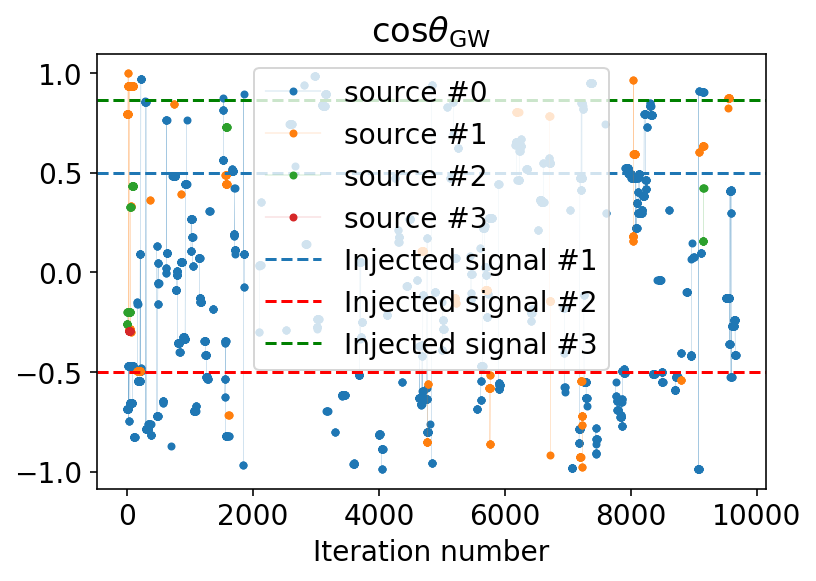

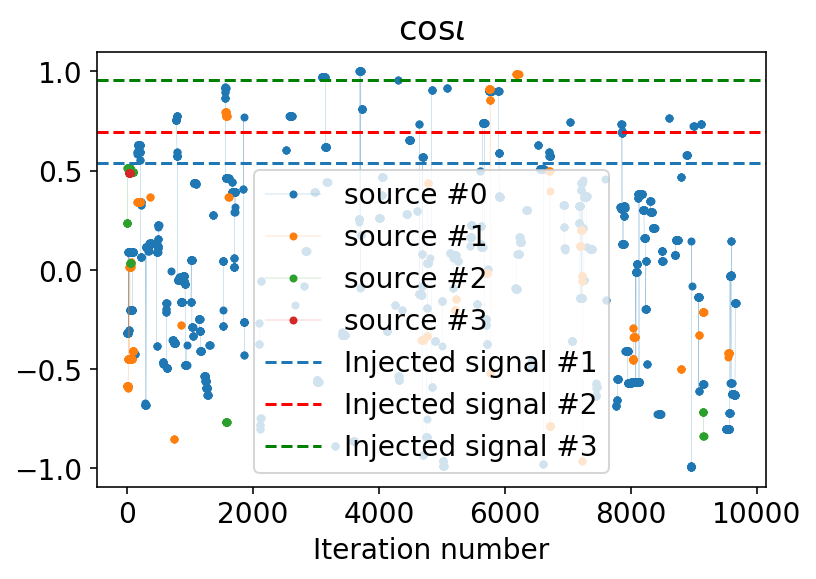

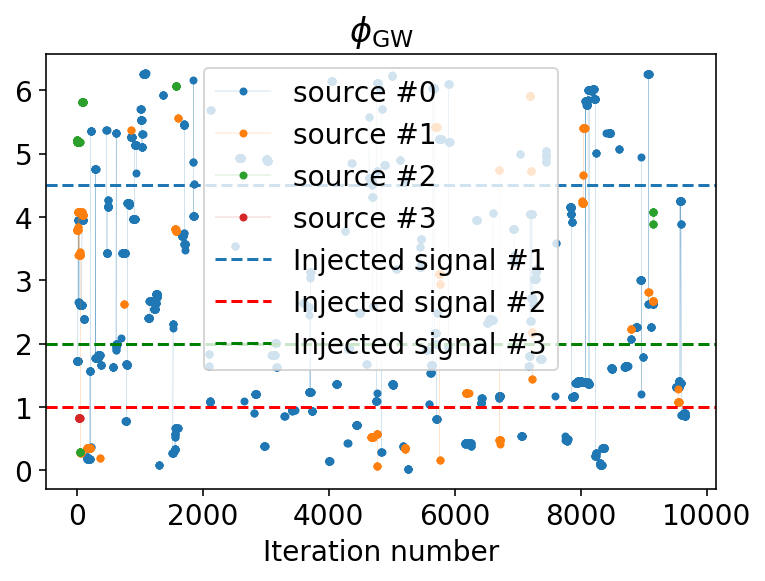

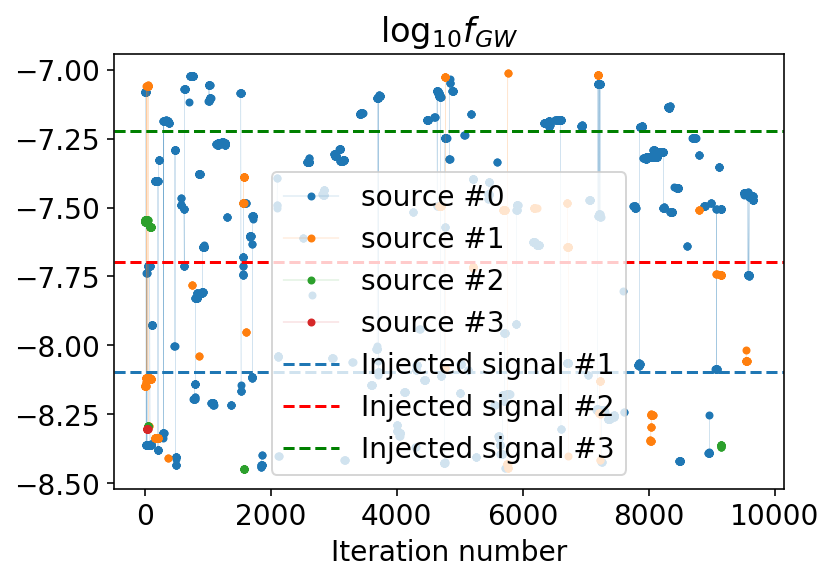

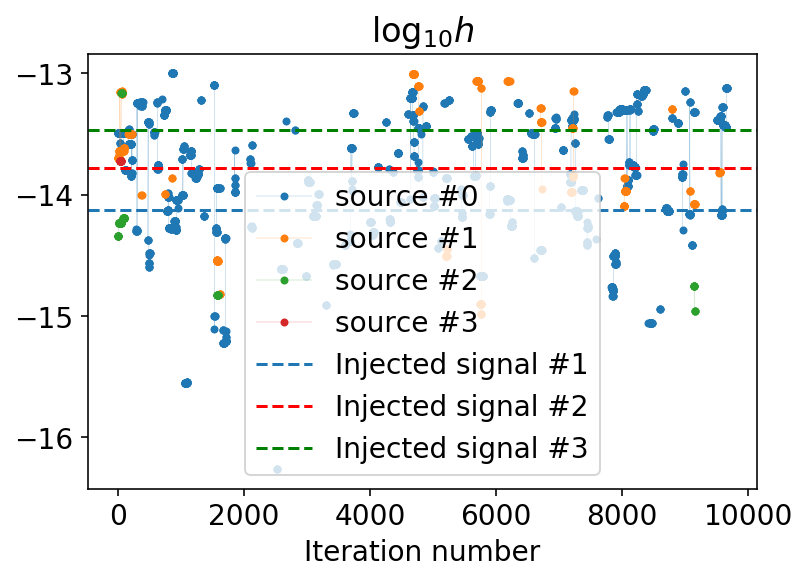

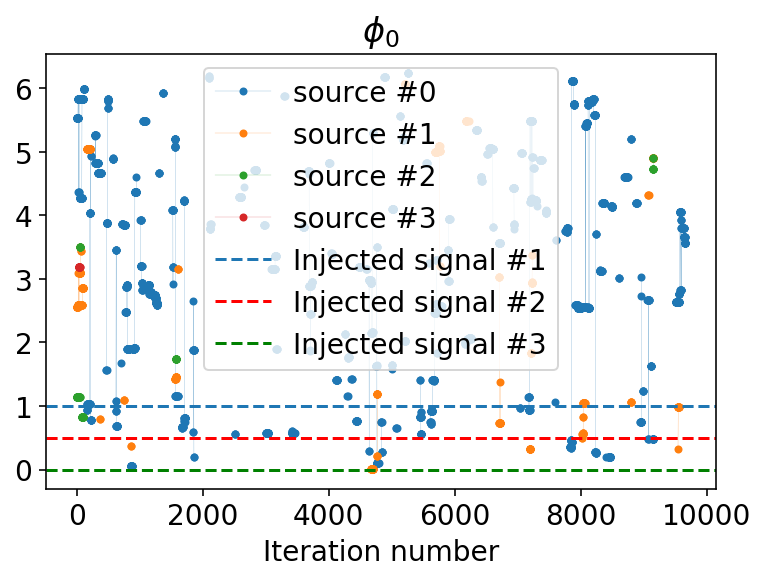

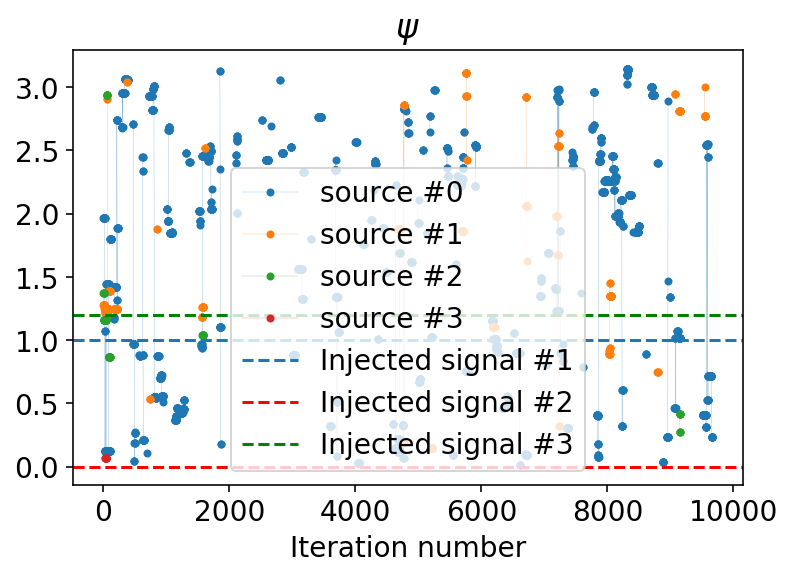

In [31]:
#################################################################
#
# CW PARAMETERS TRACE PLOT
#
#################################################################

#samples_burned = samples[0,:,:]
samples_burned = np.where(samples[0,:,:]!=0.0, samples[0,:,:], np.nan)[::]

# Make trace-plot to diagnose sampling

x0 = {'cos_gwtheta':np.cos(np.pi/3),
      'cos_inc':np.cos(1.0),
      'gwphi':4.5,
      'log10_fgw':np.log10(8e-9),
      'log10_h':-14.125,
      'phase0':1.0,
      'psi':1.0}

x1 = {'cos_gwtheta':np.cos(np.pi*2/3),
      'cos_inc':np.cos(0.8),
      'gwphi':1.0,
      'log10_fgw':np.log10(2.0e-8),
      'log10_h':-13.784824108,
      'phase0':0.5,
      'psi':0.0}

x2 = {'cos_gwtheta':np.cos(np.pi/6),
      'cos_inc':np.cos(0.3),
      'gwphi':2.0,
      'log10_fgw':np.log10(6e-8),
      'log10_h':-13.4667432715,
      'phase0':0.0,
      'psi':1.2}

print(samples_burned.shape)
n_source=int(np.nanmax(samples_burned[:,0]))

print(n_source)
titles = ['cos_gwtheta', 'cos_inc', 'gwphi', 'log10_fgw','log10_h', 'phase0', 'psi']
labels=[r'$\cos \theta_{\rm GW}$', r'$\cos \iota$', r'$\phi_{\rm GW}$', r'$\log_{10}f_{GW}$', r'$\log_{10}h$',
        r'$\phi_0$', r'$\psi$']
true_val1 = [x0[key] for key in x0.keys()]
true_val2 = [x1[key] for key in x1.keys()]
true_val3 = [x2[key] for key in x2.keys()]
print(true_val1)
#print(true_val2)

for i in range(len(true_val1)):
    plt.figure(i)
    for j in range(n_source):
        print(1+n_source*i+j)
        plt.plot(samples_burned[:,1+i+j*7], linestyle = '-', lw=0.1, marker='.', label="source #{0}".format(j))
    plt.title(labels[i])
    plt.xlabel("Iteration number")
    plt.gca().axhline(y=true_val1[i], linestyle='--', label="Injected signal #1")
    plt.gca().axhline(y=true_val2[i], color='r', linestyle='--', label="Injected signal #2")
    plt.gca().axhline(y=true_val3[i], color='g', linestyle='--', label="Injected signal #3")
    plt.legend()
    #plt.xlim((10000,20000))

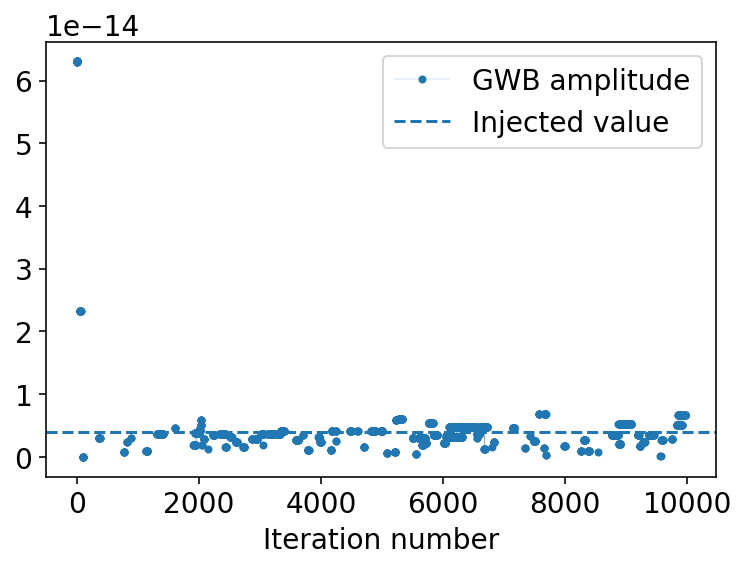

In [35]:
#################################################################
#
# GWB PARAMETERS TRACE PLOT
#
#################################################################

#plot all samples
#samples_burned = samples[0,:,:]

#or plot only samples where GWB is on
samples_burned = np.where(samples[0,:,:]!=0.0, samples[0,:,:], np.nan)[::]

#x_gwb = {'log10_amp':np.log10(1e-15),
#         'gamma':13.0/3.0}

x_gwb = {'log10_amp':-14.4,
         'gamma':13.0/3.0}

num_psrs = 5

plt.plot(10**samples_burned[:,-1], ls='-', lw=0.1, marker='.', label="GWB amplitude")
plt.gca().axhline(y=10**x_gwb['log10_amp'], linestyle='--', label="Injected value")
#plt.gca().axhline(y=10**(-18), linestyle='-', label="Prior boundary")
#plt.gca().axhline(y=10**(-13), linestyle='-')
plt.xlabel("Iteration number")
#plt.xlim((0,100000))
plt.legend()

In [37]:
#################################################################
#
# CALCULATE CORRELATION LENGTHS USED FOR BAYES-FACTOR ERROR ESTIMATIONS
#
#################################################################
import emcee

samples_burned = samples[0,:,:]

burnin = 1000

n_pulsar=5

corrs = []
for i in range(samples.shape[2]):
    try:
        if i==n_pulsar+2:
            #print(samples_burned[burnin,i])
            ccc = emcee.autocorr.integrated_time(10**samples_burned[burnin:,i], c=1)
        elif i==n_pulsar+3:
            #print((samples_burned[burnin:,i])[samples_burned[burnin:,i]!=0.0])
            ccc = emcee.autocorr.integrated_time(10**((samples_burned[burnin:,i])[samples_burned[burnin:,i]!=0.0]), c=1)
        else:
            ccc = emcee.autocorr.integrated_time(samples_burned[burnin:,i], c=1)
        #print(ccc)
        corrs.append(ccc)
    except:
        print('corr length longer than the whole chain')

corrs = np.array(corrs)
print(corrs)


##########################################
corr_correction = 1.0
##########################################

#print(np.delete(corrs,[45,46]))
max_corr_l = np.max(corrs)*corr_correction
eff_N = (samples.shape[1]-burnin)/max_corr_l

print('Maximum autocorelation length is (except RN params): {0}'.format(max_corr_l))
print('Effective number of samples: {0}'.format(eff_N))
print('We applied a correction of: {0}'.format(corr_correction))

/home/beno/anaconda3/envs/Enterprise_new/lib/python3.6/site-packages/emcee/autocorr.py:43: RuntimeWarning: invalid value encountered in true_divide
  return acf / acf[m]


corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain
corr length longer than the whole chain


[-0.5  0.5  1.5]
9000
[6880 2120]
[ 76.44444444  23.55555556]
[ 7.18752045  3.98981542]
[ 0.0940228   0.16937896]
best prior would have been: prior_on=0.7644


Text(0.5, 1.0, '$B_{\\rm GWB}^{\\rm RJ}=0.30814\\pm 0.08116$')

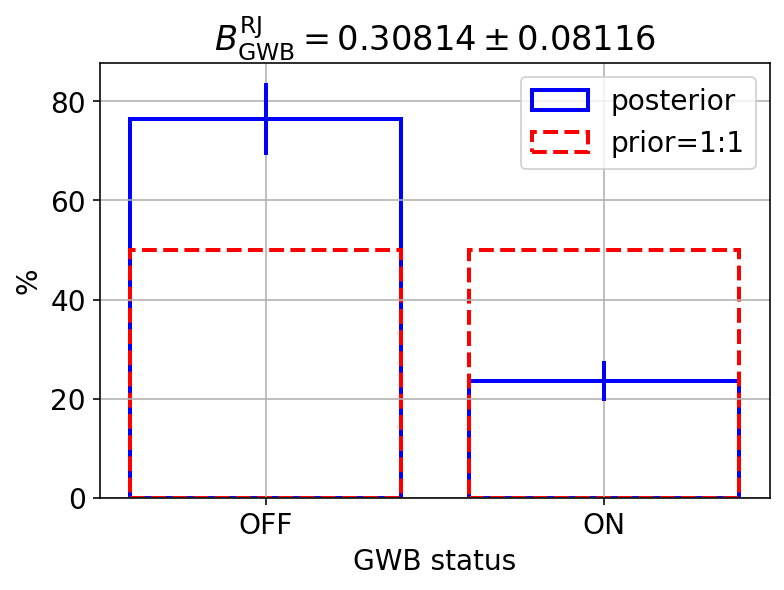

In [39]:
#################################################################
#
# GWB BAYES-FACTOR CALCULATION
#
#################################################################

burnin = 1000
#samples_burned = samples[0,:,:][burnin::int(max_corr_l)]
samples_burned = samples[0,:,:][burnin:]
#print(samples_burned[:,1+max_n_source*7+4*num_psrs])
max_n_source = 10
num_psrs = 5
gw_on = [int(x!=0) for x in samples_burned[:,-1]]

########################################
min_n = 0
max_n = 1
########################################
bins = np.arange(min_n-1,max_n+1) + 0.5
print(bins)
N = np.shape(samples_burned[:,0])[0]
print(N)
hist, bin_edges = np.histogram(gw_on, bins)
print(hist)
print(hist/N*100)
poisson_error = np.sqrt(hist/max_corr_l)/(N/max_corr_l)*100
print(poisson_error)
plt.bar(bin_edges[:-1]+0.5, hist/N*100, yerr=poisson_error, fill=False, edgecolor='b', linewidth=2, ecolor='b',
        capsize=None, error_kw={'elinewidth':2}, label='posterior')
########################################
prior_on = 0.5
########################################
prior_hist = np.array([1-prior_on, prior_on])*100
plt.bar(bin_edges[:-1]+0.5, prior_hist, fill=False, edgecolor='r', linewidth=2, ls='--',
        label='prior={0:.0f}:1'.format(prior_on/(1-prior_on)))
plt.legend()
#plt.yscale('log', nonposy='clip')
plt.xlabel("GWB status")
plt.ylabel("%")

plt.xticks(np.arange(min_n, max_n+1, step=1.0), ['OFF', 'ON'])

#plt.axhline(y=100.0/np.max(samples_burned[:,0]), color='r')
#plt.ylim((20,30))
#plt.xlim((0.5,3.0))
plt.grid(which='both')
#plt.tight_layout()

bayes_factor = hist[1]/hist[0]*(1-prior_on)/prior_on #compensating for our non-uniform prior

print(poisson_error/(hist/N*100))

bf_error = np.sum(poisson_error/(hist/N*100))*bayes_factor

print("best prior would have been: prior_on={0:.4f}".format(1-bayes_factor/(1+bayes_factor)))

#plt.text(0.65,60,r'$B_{{\rm GWB}}^{{\rm RJ}}={0:.4f}\pm {1:.4f}$'.format(bayes_factor, bf_error), fontdict={'size':10})
plt.title(r'$B_{{\rm GWB}}^{{\rm RJ}}={0:.5f}\pm {1:.5f}$'.format(bayes_factor, bf_error))

/home/beno/anaconda3/envs/Enterprise_new/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


best prior would have been: n_source_prior=  [  0.13511688   0.450045     3.44827586  14.08450704  62.5                 inf
          inf          inf          inf          inf          inf]


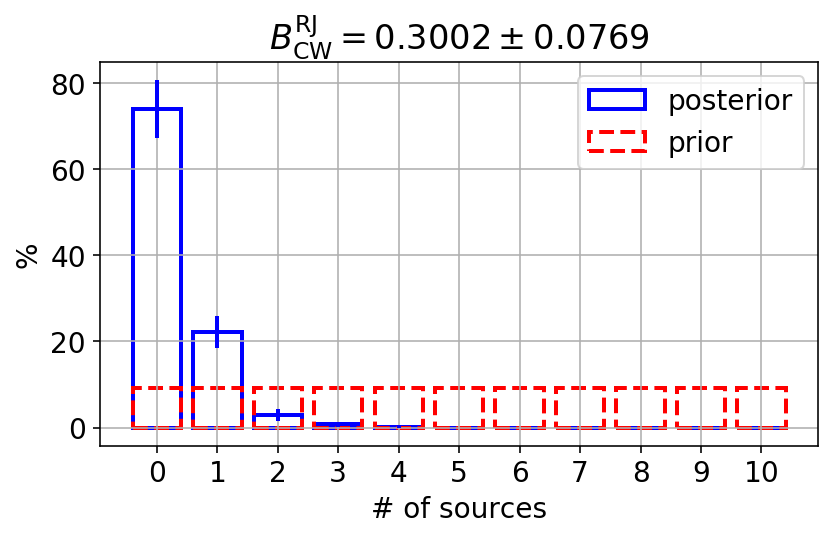

In [47]:
#################################################################
#
# NUMBER OF SOURCES HISTOGRAM + CALCULATE BAYES-FACTOR FOR 1 CW VS. 0 CW
#
#################################################################

samples_burned = samples[0,:,:]

########################################
min_n = 0
max_n = 10
#max_n = int(np.nanmax(samples_burned[:,0]))
########################################
bins = np.arange(min_n-1,max_n+1) + 0.5

N = np.shape(samples_burned[:,0])[0]

hist, bin_edges = np.histogram(samples_burned[:,0], bins)

poisson_error = np.sqrt(hist/max_corr_l)/(N/max_corr_l)*100

plt.bar(bin_edges[:-1]+0.5, hist/N*100, yerr=poisson_error, fill=False, edgecolor='b', linewidth=2, ecolor='b',
        capsize=None, error_kw={'elinewidth':2}, label='posterior')

########################################
n_source_prior = (1/1.0)**np.arange(11)
########################################
prior_hist = n_source_prior/np.sum(n_source_prior)*100
plt.bar(bin_edges[:-1]+0.5, prior_hist, fill=False, edgecolor='r', linewidth=2, ls='--',
        label='prior')

plt.legend()
plt.xlabel("# of sources")
plt.ylabel("%")

plt.xticks(np.arange(min_n, max_n+1, step=1.0))

bayes_factor = hist[1]/hist[0]*n_source_prior[0]/n_source_prior[1] #compensating for our non-uniform prior


bf_error = (poisson_error[0]/(hist[0]/N*100) + poisson_error[1]/(hist[1]/N*100))*bayes_factor

print("best prior would have been: n_source_prior= ",1/hist*1000)

plt.title(r'$B_{{\rm CW}}^{{\rm RJ}}={0:.4f}\pm {1:.4f}$'.format(bayes_factor, bf_error))

plt.grid(which='both')
plt.tight_layout()

(10000, 79)
[0.50000000000000011, 0.54030230586813977, 4.5, -8.0969100130080562, 7.498942093324559e-15, 1.0, 1.0]


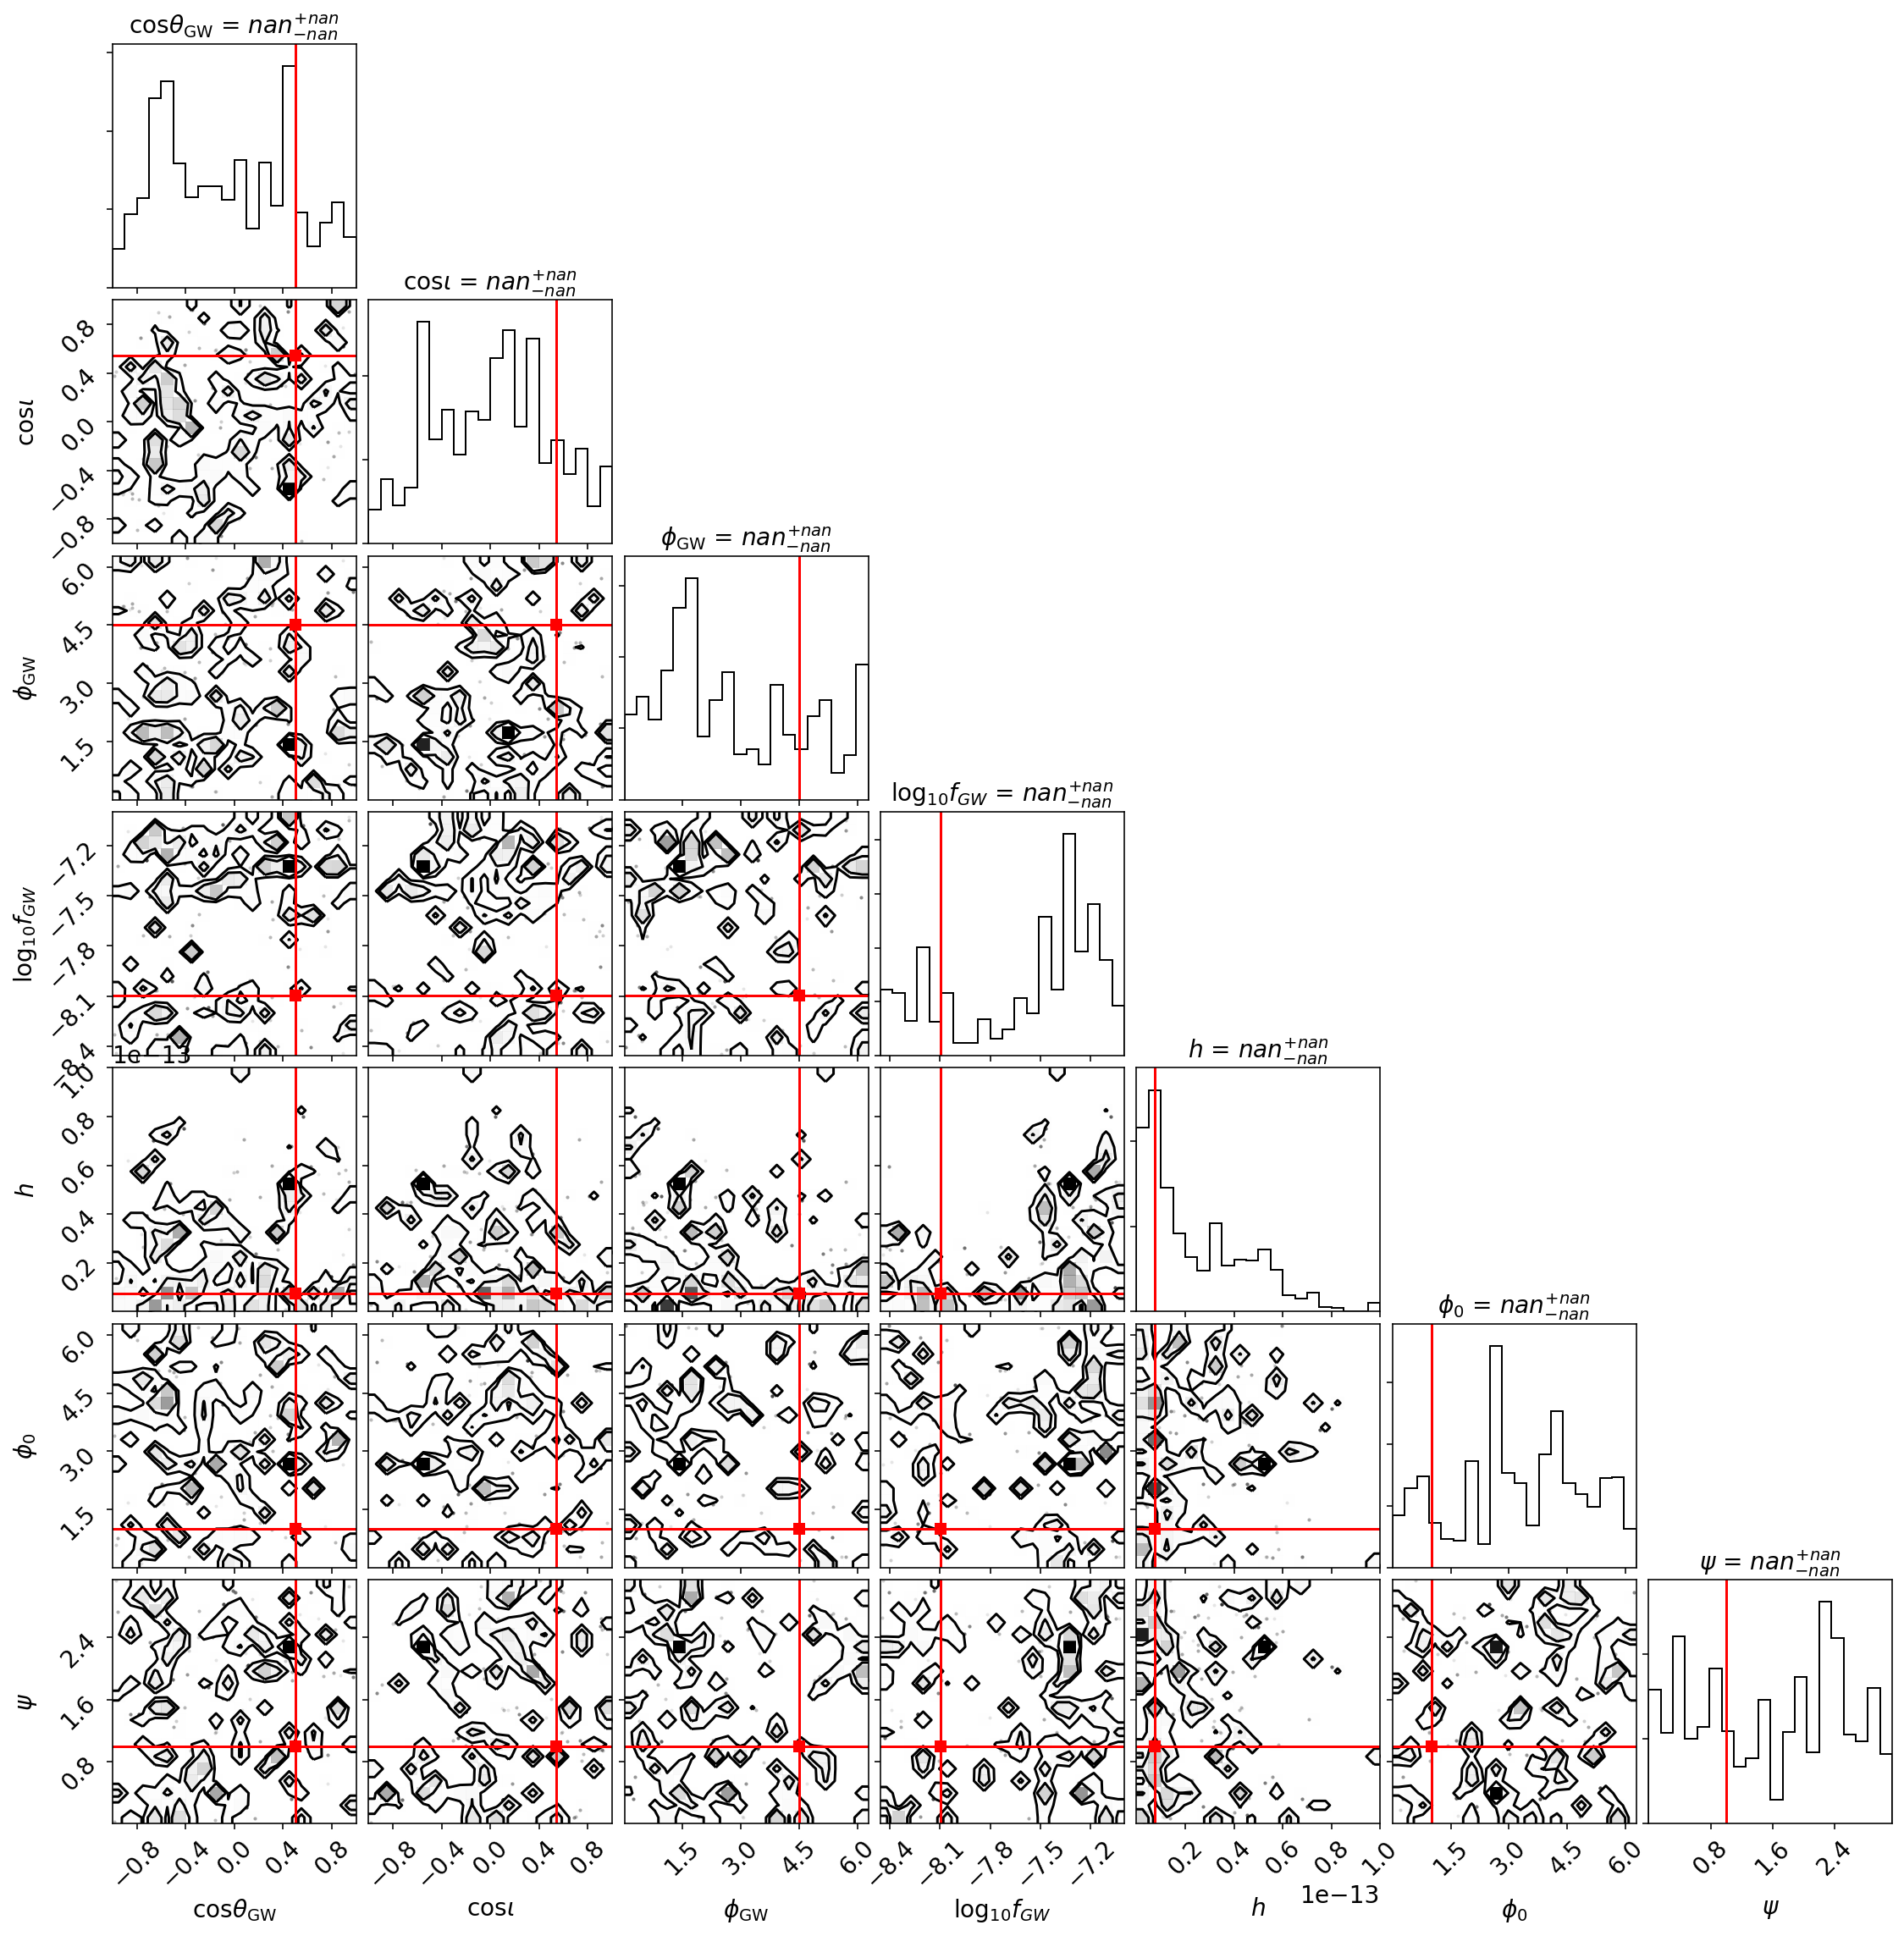

In [49]:
#################################################################
#
# CORNER PLOT OF CW PARAMETERS
#
#################################################################

samples_burned = np.where(samples[0,:,:]!=0.0, samples[0,:,:], np.nan)

print(samples_burned.shape)

labels=[r'$\cos \theta_{\rm GW}$', r'$\cos \iota$', r'$\phi_{\rm GW}$', r'$\log_{10}f_{GW}$', r'$\log_{10}h$',
        r'$\phi_0$', r'$\psi$']

true_val1 = [x0[key] for key in x0.keys()]

for i in range(5):
    samples_burned[:,5+i*7] = 10**samples_burned[:,5+i*7]
true_val1[4] = 10**true_val1[4]
labels[4] = r'$h$'

print(true_val1)

max_n_source = 10
num_psrs = 5

lw=2

from matplotlib import rcParams
rcParams["font.size"] = 14


# Make the base corner plot
figure = corner.corner(samples_burned[:,1+7*0:8+7*0], labels=labels,
                       levels=[0.68,0.95],
                       quantiles=[0.16, 0.5, 0.84],
                       range=[(-1,1), (-1,1), (0,2*np.pi),
                              (np.log10(3.5e-9), -7), (0,1e-13),
                              (0,2*np.pi), (0,np.pi)],
                       truths=true_val1, truth_color='r',
                       show_titles=True, title_kwargs={"fontsize": 14})